# Baseline model for batch monitoring example

In [19]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
files = [('green_tripdata_2022-02.parquet', './data'), ('green_tripdata_2022-01.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2022-01.parquet: 100%|█████████████| 1254291/1254291 [00:02<00:00, 488077.16it/s, save to ./data/green_tripdata_2022-01.parquet]


In [3]:
jan_data = pd.read_parquet('data/green_tripdata_2022-01.parquet')

In [4]:
jan_data.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,62495.000000,62495,62495,56200.000000,62495.000000,62495.000000,56200.000000,62495.000000,62495.000000,62495.00000,62495.000000,62495.000000,62495.000000,62495.000000,62495.000000,56200.000000,56200.000000,56200.000000
mean,1.849508,2022-01-16 14:18:36.026353920,2022-01-16 14:37:37.189551104,1.198719,97.615041,135.969902,1.258399,77.758632,13.914000,0.34756,0.426322,1.666540,0.208182,0.297312,17.490532,1.403594,1.040925,0.706628
min,1.000000,2009-01-01 00:34:01,2009-01-01 17:05:20,1.000000,1.000000,1.000000,0.000000,0.000000,-65.000000,-4.50000,-0.500000,-0.860000,-6.550000,-0.300000,-71.850000,1.000000,1.000000,0.000000
25%,2.000000,2022-01-08 23:41:50,2022-01-08 23:55:28.500000,1.000000,55.000000,74.000000,1.000000,1.080000,7.000000,0.00000,0.500000,0.000000,0.000000,0.300000,9.360000,1.000000,1.000000,0.000000
50%,2.000000,2022-01-16 15:59:42,2022-01-16 16:17:00,1.000000,75.000000,137.000000,1.000000,1.900000,10.500000,0.00000,0.500000,1.000000,0.000000,0.300000,13.860000,1.000000,1.000000,0.000000
75%,2.000000,2022-01-24 09:16:50,2022-01-24 09:37:28,1.000000,130.000000,215.000000,1.000000,3.500000,17.000000,0.50000,0.500000,2.610000,0.000000,0.300000,21.050000,2.000000,1.000000,2.750000
max,2.000000,2022-01-31 23:57:37,2022-02-01 21:01:54,5.000000,265.000000,265.000000,8.000000,224481.380000,604.500000,4.50000,0.500000,76.770000,44.750000,0.300000,605.300000,5.000000,2.000000,2.750000
std,0.357556,NaN,NaN,0.862313,62.987311,77.590956,0.877743,2909.354163,12.088819,0.65781,0.181381,2.484928,1.257659,0.037201,13.623416,0.516316,0.198119,1.201632


In [5]:
jan_data.shape

(62495, 20)

In [6]:
# create target
jan_data["duration_min"] = jan_data.lpep_dropoff_datetime - jan_data.lpep_pickup_datetime
jan_data.duration_min = jan_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [7]:
# filter out outliers
jan_data = jan_data[(jan_data.duration_min >= 0) & (jan_data.duration_min <= 60)]
jan_data = jan_data[(jan_data.passenger_count > 0) & (jan_data.passenger_count <= 8)]

<Axes: >

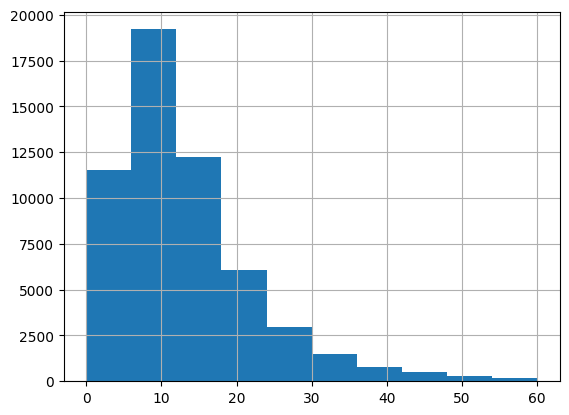

In [8]:
jan_data.duration_min.hist()

In [9]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [10]:
jan_data.shape

(55211, 21)

In [11]:
train_data = jan_data[:30000]
val_data = jan_data[30000:]

In [12]:
model = LinearRegression()

In [13]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [14]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

/var/folders/0m/qn0cdbl53ndf9_r9mm9pklgw0000gn/T/ipykernel_34124/3810346118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['prediction'] = train_preds


In [15]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

/var/folders/0m/qn0cdbl53ndf9_r9mm9pklgw0000gn/T/ipykernel_34124/3727490221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['prediction'] = val_preds


In [16]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.804665373785083
4.14206407368847


# Dump model and reference data

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [18]:
val_data.to_parquet('data/reference.parquet')

# Evidently Report

In [20]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [21]:
report = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric()
]
)

In [22]:
report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [23]:
report.show(mode='inline')

In [24]:
result = report.as_dict()

In [25]:
result

{'metrics': [{'metric': 'ColumnDriftMetric',
   'result': {'column_name': 'prediction',
    'column_type': 'num',
    'stattest_name': 'Wasserstein distance (normed)',
    'stattest_threshold': 0.1,
    'drift_score': 0.030493164661663727,
    'drift_detected': False,
    'current': {'small_distribution': {'x': [-36.73636669418323,
       -15.174383681787852,
       6.387599330607529,
       27.949582343002902,
       49.51156535539829,
       71.07354836779368,
       92.63553138018904,
       114.19751439258442,
       135.7594974049798,
       157.3214804173752,
       178.8834634297706],
      'y': [9.197953980857077e-06,
       0.0011092732500913634,
       0.04410786851980204,
       0.001078000206556449,
       4.598976990428536e-05,
       1.6556317165542753e-05,
       1.839590796171415e-06,
       3.67918159234283e-06,
       1.839590796171415e-06,
       3.67918159234283e-06]}},
    'reference': {'small_distribution': {'x': [-28.66907196717118,
       -9.81048482283424,
    

In [27]:
#prediction drift
result['metrics'][0]['result']['drift_score']

0.030493164661663727

In [29]:
#number of drifted columns
result['metrics'][1]['result']['number_of_drifted_columns']

0

In [32]:
#share of missing values
result['metrics'][2]['result']['current']['share_of_missing_values']

0.045454545454545456